In [1]:
# Tom
# Package Imports

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score, accuracy_score, precision_score, f1_score, classification_report
from sklearn.dummy import DummyRegressor, DummyClassifier

#New imports for our Pipeline workflows
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

#New imports from imblearn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

import warnings



In [2]:
df = pd.read_csv('../data/original_data.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

State, phone number, intl plan, voice mail plan are objects -- need to encode

Account Length - maybe days, how long customer has been with company

6 - 18 Usage Stats = number of calls number of minutes and charge for different time categories.

19 - # of customer service calls

Possible Churn Indicators:

- By State?
- High Customer Service Contact = high churn?
- Low Calls/Low minutes = higher churn?
- Can we identify a customer profile that is likely to churn for targeted marketing/incentives?
- Drop Phone number -- basically a unique identifer for every customer, not likely to help in predictions

- Location
    - State/Area Code
    
- Duration
    - Account Length
    
- Plan Types
    - Intl / Voicemail
    
- Usage Stats
    - minutes
    - num calls
    - charges
    - customer service calls

Drop Phone number

Encoding Process:
    - voicemail plan = labelencoder 1/0
    - international plan = 1/0
    - state - onehot encoding

Scale Numerical Features





In [4]:
# Drop phone number from the data set--in this context, it acts as a unique identifier with little meaningful context.
df.drop('phone number', axis=1, inplace=True)

Churn rate by state

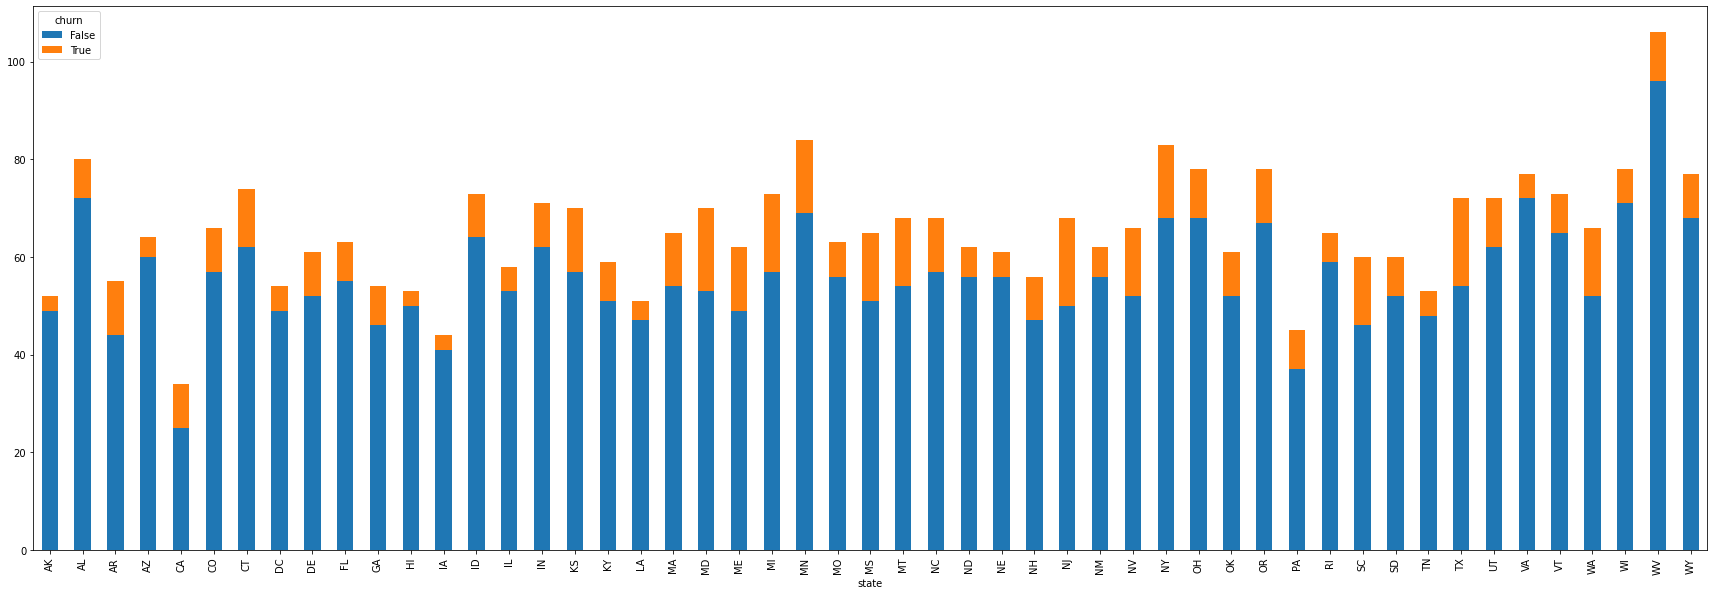

In [5]:
df.groupby(["state", "churn"]).size().unstack().plot(kind='bar', stacked=True, figsize=(30,10)); 

In [6]:
df['area code'].value_counts()

415    1655
510     840
408     838
Name: area code, dtype: int64

Churn rate by area code

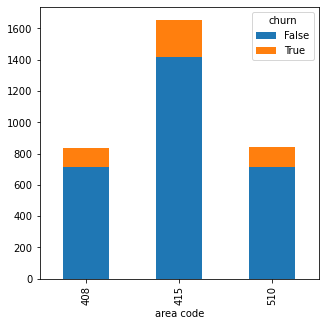

In [7]:
df.groupby(["area code", "churn"]).size().unstack().plot(kind='bar', stacked=True, figsize=(5,5));

churn rate by voice mail plan

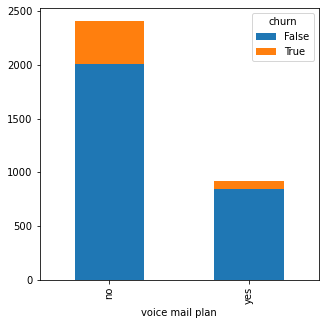

In [8]:
df.groupby(["voice mail plan", "churn"]).size().unstack().plot(kind='bar', stacked=True, figsize=(5,5));

In [9]:
df_cat = [key for key in dict(df.dtypes) if dict(df.dtypes)[key] in ['bool', 'object']]

In [10]:
df_test = df.copy()

In [11]:
le = LabelEncoder()
for i in df_cat:
    le.fit(df_test[i])
    df_test[i] = le.transform(df_test[i])


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   international plan      3333 non-null   object 
 4   voice mail plan         3333 non-null   object 
 5   number vmail messages   3333 non-null   int64  
 6   total day minutes       3333 non-null   float64
 7   total day calls         3333 non-null   int64  
 8   total day charge        3333 non-null   float64
 9   total eve minutes       3333 non-null   float64
 10  total eve calls         3333 non-null   int64  
 11  total eve charge        3333 non-null   float64
 12  total night minutes     3333 non-null   float64
 13  total night calls       3333 non-null   int64  
 14  total night charge      3333 non-null   

In [13]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   int64  
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   international plan      3333 non-null   int64  
 4   voice mail plan         3333 non-null   int64  
 5   number vmail messages   3333 non-null   int64  
 6   total day minutes       3333 non-null   float64
 7   total day calls         3333 non-null   int64  
 8   total day charge        3333 non-null   float64
 9   total eve minutes       3333 non-null   float64
 10  total eve calls         3333 non-null   int64  
 11  total eve charge        3333 non-null   float64
 12  total night minutes     3333 non-null   float64
 13  total night calls       3333 non-null   int64  
 14  total night charge      3333 non-null   

In [14]:
X2 = df_test.drop('churn', axis=1)
y2 = df_test['churn']

In [15]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, random_state=42, test_size=0.33)

In [16]:
rf_test = RandomForestClassifier()
rf_test.fit(X_train2,y_train2)

RandomForestClassifier()

Seeing which feature in the data is most impactful at determining churn rate

[0.02787417 0.03168381 0.0083032  0.0819558  0.01588826 0.02693047
 0.12926311 0.03008324 0.13903633 0.06386791 0.02877608 0.06128192
 0.03873746 0.03246721 0.03623872 0.03870959 0.04652755 0.04462542
 0.11774976]


<AxesSubplot:>

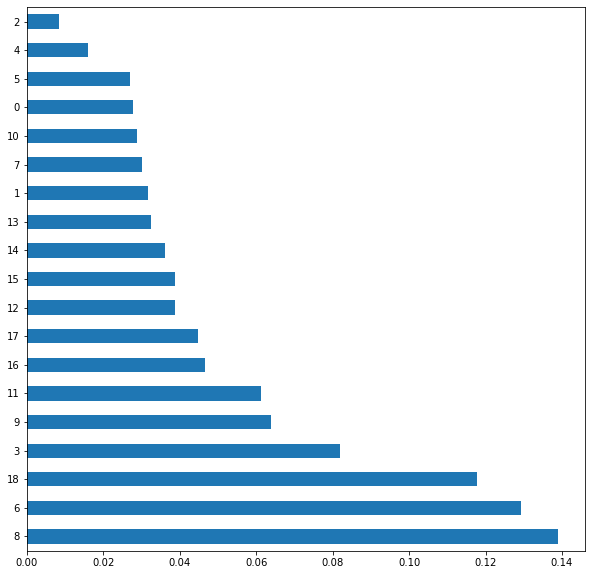

In [17]:
# Random Forest Feature Importance
feature_importance = rf_test.feature_importances_
print (rf_test.feature_importances_)
feat_importances = pd.Series(rf_test.feature_importances_)
feat_importances = feat_importances.nlargest(19)
feat_importances.plot(kind='barh' , figsize=(10,10)) 

# Train Test Split

In [18]:
X = df.drop('churn', axis=1)
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.33)

In [19]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2233 entries, 2360 to 3174
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   2233 non-null   object 
 1   account length          2233 non-null   int64  
 2   area code               2233 non-null   int64  
 3   international plan      2233 non-null   object 
 4   voice mail plan         2233 non-null   object 
 5   number vmail messages   2233 non-null   int64  
 6   total day minutes       2233 non-null   float64
 7   total day calls         2233 non-null   int64  
 8   total day charge        2233 non-null   float64
 9   total eve minutes       2233 non-null   float64
 10  total eve calls         2233 non-null   int64  
 11  total eve charge        2233 non-null   float64
 12  total night minutes     2233 non-null   float64
 13  total night calls       2233 non-null   int64  
 14  total night charge      2233 non-null

In [20]:
X_train['voice mail plan'].value_counts()

no     1621
yes     612
Name: voice mail plan, dtype: int64

In [21]:
# Define datatype of columns
num_cols = [1, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
cat_cols = [0, 3, 4]

# IMBLearn Pipeline for SMOTE

In [22]:
from imblearn.over_sampling import SMOTENC
from sklearn.feature_extraction.text import TfidfVectorizer

In [23]:
# Google says avg churn rate is 22% for all providers, much lower for the major ones

sm = SMOTENC(cat_cols, sampling_strategy=0.75, random_state=42)

In [24]:
# Define functions to identify and select columns based on the datatype stored in that column.
def get_numeric(df):
    return df.select_dtypes(include=['float', 'int'])

def get_categorical(df):
    return df.select_dtypes(include=['bool', 'object'])


# Create transformer objects using our get functions
GetNumeric = FunctionTransformer(get_numeric)
GetCategories = FunctionTransformer(get_categorical)

In [25]:
# Subpipelines to select and scale our numeric data / select and one-hot encode our categorical data.
subpipe_num = Pipeline(steps=[('num', GetNumeric),
                                ('ss', StandardScaler())])
 
subpipe_ohe = Pipeline(steps=[('cat', GetCategories), 
                              ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

subpipe_ord = Pipeline(steps=[('ord', OrdinalEncoder())])

In [26]:
# Create lists of numeric and categorical columns.
num_cols = [1, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
num_cols = list(df.columns[num_cols])
cat_cols = ['state']
ord_cols = [3, 4]
ord_cols = list(df.columns[ord_cols])

# Create ColumnTransformer object that contains our subpipes for column transformation
CT = ColumnTransformer(transformers=[
                                    ('subpipe_num', subpipe_num, num_cols),
                                    ('subpipe_ohe', subpipe_ohe, cat_cols),
                                    ('subpipe_ord', subpipe_ord, ord_cols)]
                      )

In [27]:
# Template, any model can be appended to the end.
template_model_pipe = ImPipeline(steps=[
                                        ('ct', CT),
                                        ('sm', sm),
                                        ('dc', DummyClassifier(strategy='most_frequent', random_state=42))
                                       ]
                                )

In [28]:
template_model_pipe.fit(X_train, y_train)
template_model_pipe.score(X_train, y_train)

0.8553515450067174

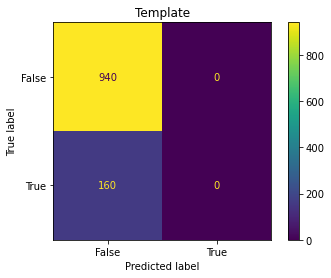

In [29]:
plot_confusion_matrix(template_model_pipe, X_test, y_test)
title = 'Template'
plt.title(title);

# Function to get column names from our model pipelines.

In [30]:
# Credit to Joey Gao @ https://github.com/scikit-learn/scikit-learn/issues/12525 for the shell of this function.

def get_column_names_from_ColumnTransformer(column_transformer):    
    col_name = []
    for transformer_in_columns in column_transformer.transformers_:#the last transformer is ColumnTransformer's 'remainder'
        raw_col_name = transformer_in_columns[2]
        if isinstance(transformer_in_columns[1],Pipeline): 
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        try:
            names = transformer.get_feature_names()
        except AttributeError: # if no 'get_feature_names' function, use raw column name
            names = raw_col_name
        if isinstance(names,np.ndarray): # eg.
            col_name += names.tolist()
        elif isinstance(names,list):
            col_name += names    
        elif isinstance(names,str):
            col_name.append(names)
    return col_name

# Cross-val function

In [31]:
# Maybe come back to this and add other scoring methods?

def cross_val(model, X, y, kfolds=10):
    """ Perform cross-validated scoring and store/print results """
    f1_results = cross_val_score(model, X, y, cv=kfolds, scoring='f1')
    f1_mean = np.mean(f1_results)
    f1_median = np.median(f1_results)
    f1_std = np.std(f1_results)
    print(f"Mean f1 score: ", {f1_mean}, ".")
    print(f"Median f1 score: ", {f1_median}, ".")
    
    
    
def get_feature_importance(model, mod_type, X, y):
    """ 
    Get feature importances, create dictionary of labels & importances and plot horizontal bar graph
    """
    
    feature_importance = model.named_steps[mod_type].feature_importances_
    feature_names = get_column_names_from_ColumnTransformer(CT)
   # ohe_feature_names = model.named_steps['ct'].named_transformers_['subpipe_ohe'].named_steps['ohe'].get_feature_names()
   # ord_feature_names = ['voice mail plan', 'international plan']
  #  feature_names = list(ohe_feature_names) + ord_feature_names
    
    print(feature_importance)
    feat_importances = pd.DataFrame(model.named_steps[mod_type].feature_importances_, index=feature_names)
    feat_importances = feat_importances[0].nlargest(19)
    feat_importances.plot(kind='barh' , figsize=(10,10)) 
    

# Class for model pipelines


In [ ]:
class model_cv_fi():
    """ 
    Cross validate f1 score and get/graph feature importances 
    """
    
    def __init__ (self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        
        self.f1_results = None
        self.f1_mean = None
        self.f1_median = None
        self.f1_std = None
        
        if cv_now == True:
            self.cross_val()
            
    def cross_val(self, X=None, y=None, kfolds=10):
        """ 
        Perform cross-validated scoring and store/print results
        """
    
        f1_X = X if X else self.X
        f1_y = y if y else self.y
    
        f1_results = cross_val_score(model, f1_X, f1_y, cv=kfolds, scoring='f1')
        f1_mean = np.mean(f1_results)
        f1_median = np.median(f1_results)
        f1_std = np.std(f1_results)
        print(f"Mean f1 score: ", {f1_mean}, ".")
        print(f"Median f1 score: ", {f1_median}, ".")   
        print(f"Std of f1 score: ", {f1_std}, ".")
        
    def get_feature_importance(self, X=None, y=None):
        """ 
        Get feature importances and plot horizontal bar graph
        """
    
        feature_importance = self.feature_importances_
        print(feature_importance)
        feat_importances = pd.Series(self.feature_importances_)
        feat_importances = feat_importances.nlargest(19)
        feat_importances.plot(kind='barh' , figsize=(10,10)) 
        
        
        
# error handling for get_feature_importances

# DecisionTree

In [32]:
from sklearn.tree import DecisionTreeClassifier

In [33]:
dt_pipeline = ImPipeline(steps=[
                                        ('ct', CT),
                                        ('sm', sm),
                                        ('dt', DecisionTreeClassifier(random_state=42))
                                       ]
                                )

In [34]:
dt_pipeline.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num',
                                                                   FunctionTransformer(func=<function get_numeric at 0x7faf940208b0>)),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['account length',
                                                   'area code',
                                                   'number vmail messages',
                                                   'total day minutes',
                                                   'total day calls',
                                                   'total day charge',
                                                   'total eve minutes',
                                               

In [35]:
dt_y_hat = dt_pipeline.predict(X_train)
print(classification_report(y_train, dt_y_hat))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00      1910
        True       1.00      1.00      1.00       323

    accuracy                           1.00      2233
   macro avg       1.00      1.00      1.00      2233
weighted avg       1.00      1.00      1.00      2233



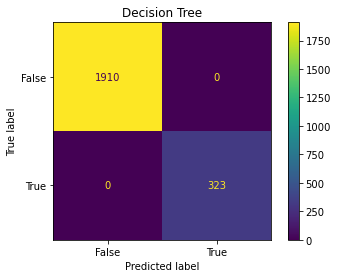

In [36]:
plot_confusion_matrix(dt_pipeline, X_train, y_train)
title = 'Decision Tree'
plt.title(title);

In [37]:
#Cross-validate decision tree

cross_val(dt_pipeline, X_train, y_train)

Mean f1 score:  {0.6635840891367175} .
Median f1 score:  {0.6664094153964885} .


[8.11447111e-03 5.28906029e-03 4.47581029e-02 9.33538960e-02
 6.38524597e-03 2.04592502e-01 6.67714757e-02 6.10849836e-03
 1.17526079e-02 5.95638011e-03 1.36966841e-02 1.25790541e-02
 5.36414804e-02 3.22938271e-02 2.95288689e-03 1.86627597e-01
 0.00000000e+00 1.20417576e-03 0.00000000e+00 2.21712865e-03
 3.93250098e-04 2.48103527e-03 0.00000000e+00 8.88629828e-03
 0.00000000e+00 1.14278641e-03 0.00000000e+00 1.19882981e-03
 0.00000000e+00 5.92428718e-04 1.13681945e-03 2.02413341e-04
 0.00000000e+00 0.00000000e+00 1.13726480e-03 5.58116294e-04
 1.20185334e-03 2.13237584e-04 1.92333629e-04 1.23655786e-03
 0.00000000e+00 1.59355828e-03 1.07208799e-02 1.57386363e-03
 0.00000000e+00 5.09657323e-03 2.33773268e-04 3.70883293e-03
 4.40492584e-03 0.00000000e+00 2.73146078e-04 2.45363894e-03
 0.00000000e+00 1.11623259e-03 2.29640942e-03 7.13573921e-04
 4.01865886e-04 2.62934496e-03 0.00000000e+00 8.14627066e-03
 1.84261552e-04 6.10942116e-04 0.00000000e+00 2.30793431e-03
 1.25983870e-03 1.629178

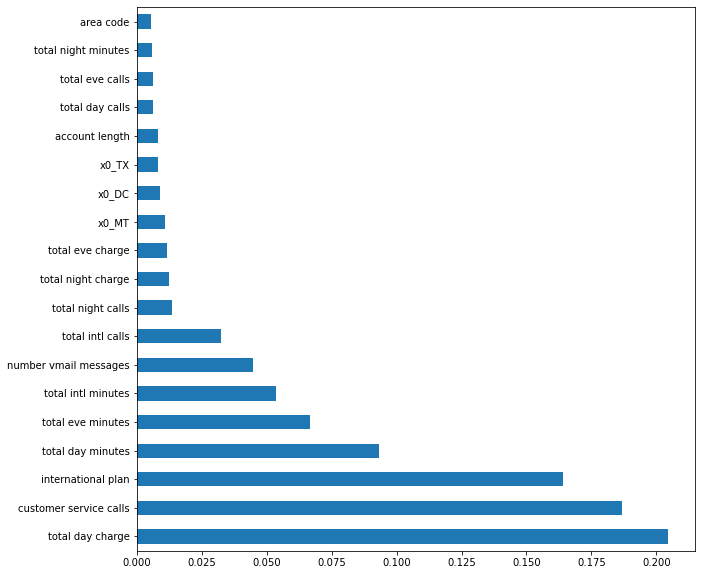

In [40]:
feat_importances = get_feature_importance(dt_pipeline, 'dt', X_train, y_train)

# KNN

In [43]:
from sklearn.neighbors import KNeighborsClassifier

In [44]:
knn_pipeline = ImPipeline(steps=[
                                        ('ct', CT),
                                        ('sm', sm),
                                        ('knn', KNeighborsClassifier())
                                       ]
                                )

In [45]:
knn_pipeline.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num',
                                                                   FunctionTransformer(func=<function get_numeric at 0x7faf940208b0>)),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['account length',
                                                   'area code',
                                                   'number vmail messages',
                                                   'total day minutes',
                                                   'total day calls',
                                                   'total day charge',
                                                   'total eve minutes',
                                               

In [46]:
knn_y_hat = knn_pipeline.predict(X_train)
print(classification_report(y_train, knn_y_hat))

              precision    recall  f1-score   support

       False       0.99      0.89      0.94      1910
        True       0.60      0.95      0.74       323

    accuracy                           0.90      2233
   macro avg       0.80      0.92      0.84      2233
weighted avg       0.93      0.90      0.91      2233



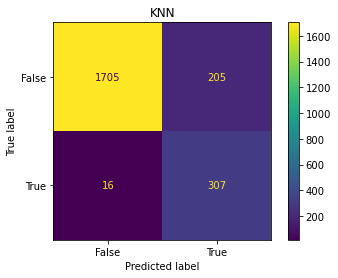

In [47]:
plot_confusion_matrix(knn_pipeline, X_train, y_train)
title = 'KNN'
plt.title(title);

In [48]:
cross_val(knn_pipeline, X_train, y_train)

Mean f1 score:  {0.4649681342946387} .
Median f1 score:  {0.4651791751183232} .


# Logistic Regression

In [49]:
lr_pipeline = ImPipeline(steps=[
                                        ('ct', CT),
                                        ('sm', sm),
                                        ('lr', LogisticRegression(random_state=42))
                                       ]
                                )

In [50]:
lr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num',
                                                                   FunctionTransformer(func=<function get_numeric at 0x7faf940208b0>)),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['account length',
                                                   'area code',
                                                   'number vmail messages',
                                                   'total day minutes',
                                                   'total day calls',
                                                   'total day charge',
                                                   'total eve minutes',
                                               

In [51]:
lr_y_hat = lr_pipeline.predict(X_test)
print(classification_report(y_test, lr_y_hat))

              precision    recall  f1-score   support

       False       0.94      0.83      0.88       940
        True       0.40      0.68      0.50       160

    accuracy                           0.81      1100
   macro avg       0.67      0.75      0.69      1100
weighted avg       0.86      0.81      0.82      1100



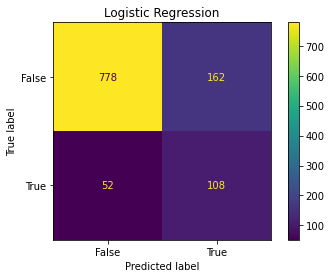

In [52]:
plot_confusion_matrix(lr_pipeline, X_test, y_test)
title = 'Logistic Regression'
plt.title(title);

In [53]:
cross_val(lr_pipeline, X_train, y_train)

Mean f1 score:  {0.4717149176911243} .
Median f1 score:  {0.4578977932636469} .


# Random Forest

In [54]:
from sklearn.ensemble import RandomForestClassifier

In [55]:
rf_pipeline = ImPipeline(steps=[
                                        ('ct', CT),
                                        ('sm', sm),
                                        ('rf', RandomForestClassifier(random_state=42))
                                       ]
                                )

In [56]:
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num',
                                                                   FunctionTransformer(func=<function get_numeric at 0x7faf940208b0>)),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['account length',
                                                   'area code',
                                                   'number vmail messages',
                                                   'total day minutes',
                                                   'total day calls',
                                                   'total day charge',
                                                   'total eve minutes',
                                               

In [57]:
rf_y_hat = rf_pipeline.predict(X_test)
print(classification_report(y_test, rf_y_hat))

              precision    recall  f1-score   support

       False       0.96      0.98      0.97       940
        True       0.88      0.76      0.81       160

    accuracy                           0.95      1100
   macro avg       0.92      0.87      0.89      1100
weighted avg       0.95      0.95      0.95      1100



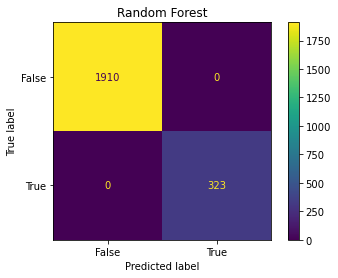

In [58]:
plot_confusion_matrix(rf_pipeline, X_train, y_train)
title = 'Random Forest'
plt.title(title);

In [59]:
cross_val(rf_pipeline, X_train, y_train)

Mean f1 score:  {0.7744746902526841} .
Median f1 score:  {0.782687651331719} .


# Naive Bayes

In [60]:
from sklearn.naive_bayes import GaussianNB

In [61]:
nb_pipeline = ImPipeline(steps=[
                                        ('ct', CT),
                                        ('sm', sm),
                                        ('nb', GaussianNB())
                                       ]
                                )

In [62]:
nb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num',
                                                                   FunctionTransformer(func=<function get_numeric at 0x7faf940208b0>)),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['account length',
                                                   'area code',
                                                   'number vmail messages',
                                                   'total day minutes',
                                                   'total day calls',
                                                   'total day charge',
                                                   'total eve minutes',
                                               

In [63]:
nb_y_hat = nb_pipeline.predict(X_train)
print(classification_report(y_train, nb_y_hat))

              precision    recall  f1-score   support

       False       0.91      0.58      0.71      1910
        True       0.21      0.67      0.32       323

    accuracy                           0.60      2233
   macro avg       0.56      0.63      0.52      2233
weighted avg       0.81      0.60      0.66      2233



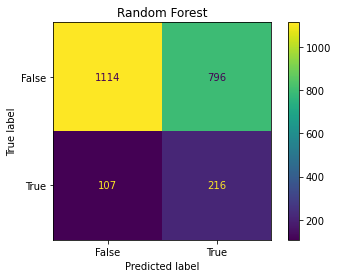

In [64]:
plot_confusion_matrix(nb_pipeline, X_train, y_train)
title = 'Random Forest'
plt.title(title);

In [65]:
cross_val(nb_pipeline, X_train, y_train)

Mean f1 score:  {0.2821166576380337} .
Median f1 score:  {0.2871475523265871} .


# Gradiant Boosted 

In [66]:
from sklearn.ensemble import GradientBoostingClassifier

In [67]:
gbc_pipeline = ImPipeline(steps=[
                                        ('ct', CT),
                                        ('sm', sm),
                                        ('gbc', GradientBoostingClassifier())
                                       ]
                                )

In [68]:
gbc_pipeline.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num',
                                                                   FunctionTransformer(func=<function get_numeric at 0x7faf940208b0>)),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['account length',
                                                   'area code',
                                                   'number vmail messages',
                                                   'total day minutes',
                                                   'total day calls',
                                                   'total day charge',
                                                   'total eve minutes',
                                               

In [69]:
gbc_y_hat = gbc_pipeline.predict(X_train)
print(classification_report(y_train, gbc_y_hat))

              precision    recall  f1-score   support

       False       0.97      0.99      0.98      1910
        True       0.92      0.80      0.86       323

    accuracy                           0.96      2233
   macro avg       0.94      0.90      0.92      2233
weighted avg       0.96      0.96      0.96      2233



In [70]:
cross_val(gbc_pipeline, X_train, y_train)

Mean f1 score:  {0.7620596138052165} .
Median f1 score:  {0.7400793650793651} .
